In [1]:
import tdt
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tkinter import Tk
from tkinter import filedialog
from readSGLX import readMeta, SampRate, makeMemMapRaw, ExtractDigital
from sklearn.linear_model import LinearRegression
from scipy.io import savemat
from warnings import warn
from barcodes import extract_barcodes_from_times
from difflib import SequenceMatcher

In [2]:
def plot_pulses(onset_times, offset_times, nPulsesToPlot=20):
    '''Use onset and offset times to plot pulse waveforms. 
    Times should be in seconds. Plot only the first N pulses (default 100)'''
    
    #Interleave onset and offset times
    edge_times = np.empty((onset_times.size + offset_times.size,), dtype=onset_times.dtype)
    edge_times[0::2] = onset_times
    edge_times[1::2] = offset_times
    
    # Figure out when pulses are high and when they are low
    sync_levels = np.empty((onset_times.size + offset_times.size,), dtype=onset_times.dtype)
    sync_levels[0::2] = 1
    sync_levels[1::2] = 0

    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.step(edge_times[:nPulsesToPlot], sync_levels[:nPulsesToPlot], where='post')

# Load SGLX

In [3]:
def select_sglx_file():
    '''Select a SGLX binary file to extract the digtial sync bit from. 
    Using the LFP file is faster, but the AP file is maximally precise.'''

    
    # Get file from user
    root = Tk()         # create the Tkinter widget
    root.withdraw()     # hide the Tkinter root window

    # Windows specific; forces the window to appear in front
    root.attributes("-topmost", True)

    fullPath = Path(filedialog.askopenfilename(title="Select SpikeGLX binary file"))

    root.destroy()
    
    return fullPath

In [4]:
def sglx_load_sync(sglx_file):
    '''Load the sync channel from the specified binary file. 
    The SpikeGLX metadata file must be present in the same directory as the binary file.'''
    meta = readMeta(sglx_file)
    rawData = makeMemMapRaw(sglx_file, meta)

    # Read the entire file
    firstSamp = 0
    lastSamp = rawData.shape[1]-1

    # Which digital word to read. 
    # For imec, there is only 1 digital word, dw = 0.
    # For NI, digital lines 0-15 are in word 0, lines 16-31 are in word 1, etc.
    dw = 0    
    # Which lines within the digital word, zero-based
    # Note that the SYNC line for PXI 3B is stored in line 6.
    dLineList = [6]
        
    return ExtractDigital(rawData, firstSamp, lastSamp, dw, dLineList, meta)

In [5]:
def sglx_onset_samples(sync):
    '''Extract the pulse rising edge samples from the SGLX sync channel.'''
    # Onsets are the first samples where a value is high after being low. If sample 0 is high, the first onset is sample 0. Consistent with TDT convention.
    onset_samples = np.where(np.diff(np.squeeze(sync), prepend=0) == 1)[0]
    assert(onset_samples.dtype == np.dtype('int64')) # Make sure uint8s have been properly casted as int64s
    return onset_samples

In [6]:
def sglx_offset_samples(sync):
    '''Extract the pulse falling edge samples from the SGLX sync channel'''
    # Offsets are the first samples wehre a value is low after being high. If the last sample is high, the last offset is Inf. Consistent with TDT convention.
    offset_samples = np.where(np.diff(np.squeeze(sync), prepend=0) == -1)[0]
    assert(offset_samples.dtype == np.dtype('int64')) # Make sure uint8s have been properly casted as int64s
    if np.squeeze(sync)[-1] == 1:
        offset_samples = np.append(offset_samples, np.Inf)
    return offset_samples

In [7]:
def get_rising_edges(onset_times):
    '''Assumes onset times follow TDT convention, as described above.'''
    return onset_times[np.where(onset_times > 0)]

In [8]:
def get_falling_edges(offset_times):
    '''Assumes offset times follow TDT convention, as described above '''
    return offset_times[np.where(offset_times < np.Inf)]

In [9]:
sglx_file = select_sglx_file()
sglx_sync = sglx_load_sync(sglx_file)
sglx_fs = SampRate(readMeta(sglx_file))
# Times are in seconds from the start of the SGLX recording. 
sglx_onset_times = sglx_onset_samples(sglx_sync) / sglx_fs
sglx_offset_times = sglx_offset_samples(sglx_sync) / sglx_fs

nChan: 385, nFileSamp: 2702692


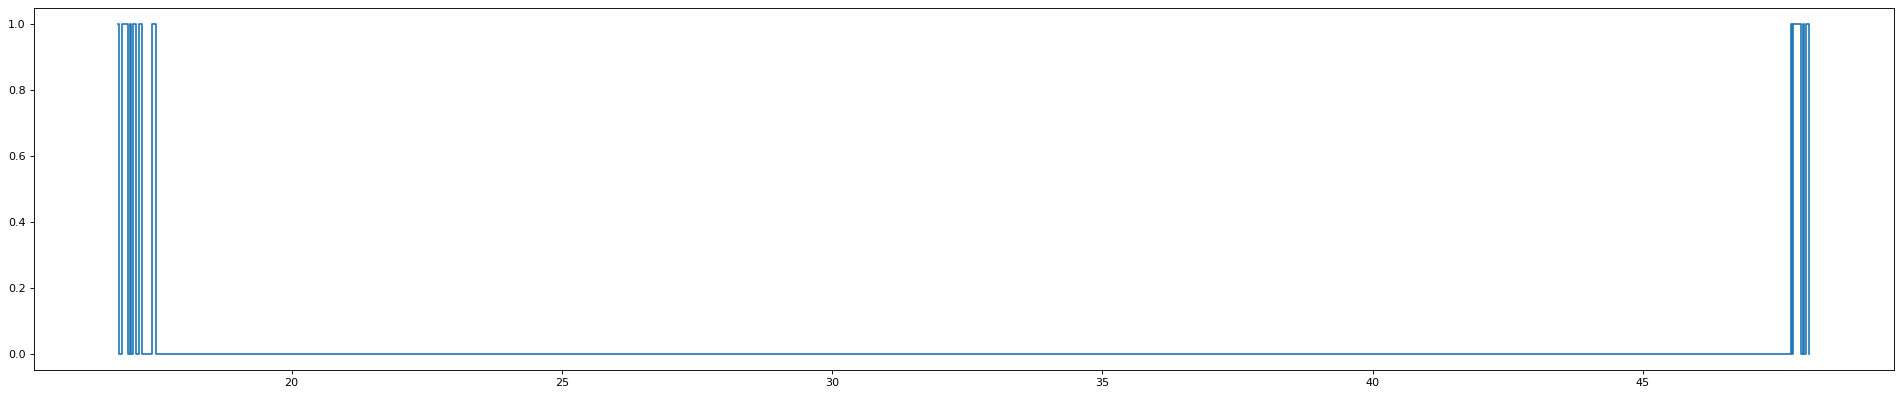

In [10]:
plot_pulses(sglx_onset_times, sglx_offset_times, nPulsesToPlot=20)

In [11]:
sglx_rising_edges = get_rising_edges(sglx_onset_times)
sglx_falling_edges = get_falling_edges(sglx_offset_times)
sglx_barcode_start_times, sglx_barcodes = extract_barcodes_from_times(sglx_rising_edges, sglx_falling_edges, bar_duration=0.029)

# Load TDT

In [12]:
def select_tdt_block():
    '''Select a TDT block to extract sync info from.'''
    # Get file from user
    root = Tk()         # create the Tkinter widget
    root.withdraw()     # hide the Tkinter root window

    # Windows specific; forces the window to appear in front
    root.attributes("-topmost", True)

    fullPath = Path(filedialog.askdirectory(title="Select TDT block"))

    root.destroy()
    
    return fullPath

In [13]:
tdt_file = select_tdt_block()
tdt_data = tdt.read_block(tdt_file, evtype=['epocs'])
# Here, we assume that your digital sync pulse is recorded on Port C0
# YSK: TDT calls the onset of a signal that starts high "0", but the offset of a signal that ends high "inf"
# Times are in seconds from the start of the TDT recording. 
tdt_onset_times = tdt_data.epocs.PC0_.onset 
tdt_offset_times = tdt_data.epocs.PC0_.offset

read from t=0s to t=1015.12s


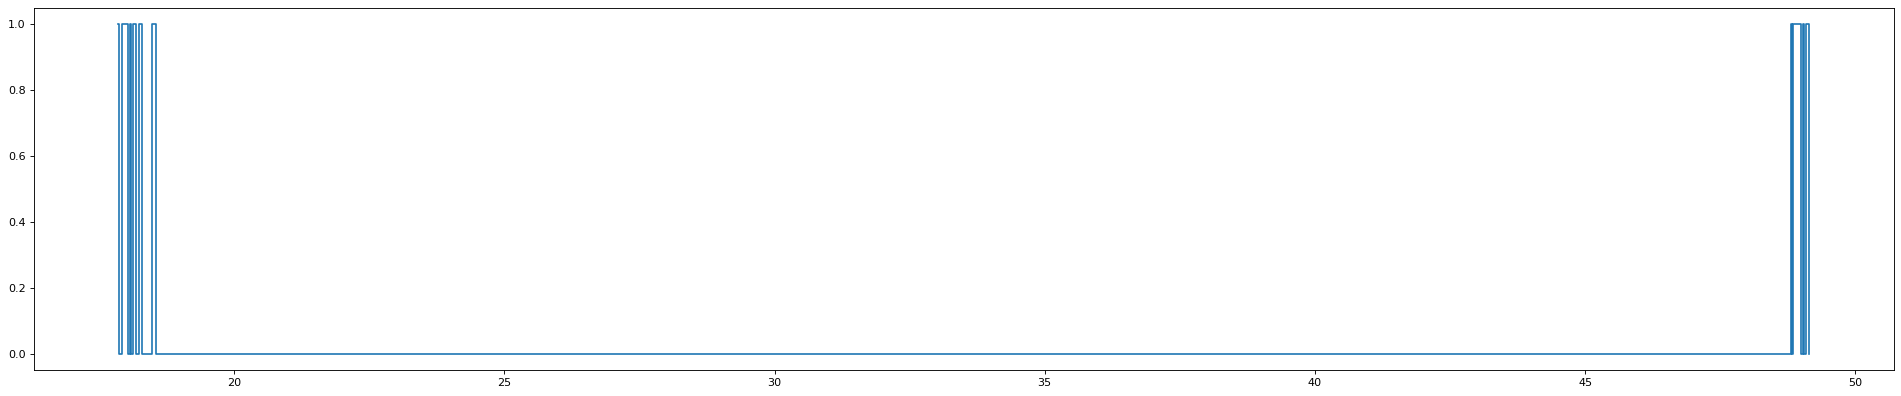

In [14]:
plot_pulses(tdt_onset_times, tdt_offset_times, nPulsesToPlot=20)

In [15]:
tdt_rising_edges = get_rising_edges(tdt_onset_times)
tdt_falling_edges = get_falling_edges(tdt_offset_times)
tdt_barcode_start_times, tdt_barcodes = extract_barcodes_from_times(tdt_rising_edges, tdt_falling_edges, bar_duration=0.029)

# Use barcodes to align streams

In [16]:
print(sglx_barcode_start_times)
print(tdt_barcode_start_times)

[  47.74466789   78.70298223  109.66129657  140.61961091  171.57832525
  202.53663959  233.49495394  264.45326828  295.41158262  326.37029696
  357.3286113   388.28692564  419.24523998  450.20355432  481.16226866
  512.120583    543.07889734  574.03721168  604.99552602  635.95424036
  666.9121547   697.87046904  728.82918338  759.78749772  790.74581206
  821.7041264   852.66284074  883.62115508  914.57946942  945.53818376
  976.4964981  1007.45521244 1038.41352678 1069.37184112]
[  48.81174528   79.77025536  110.72872448  141.68723456  172.64574464
  203.60425472  234.5627648   265.52123392  296.47978496  327.43829504
  358.39680512  389.3553152   420.31382528  451.27233536  482.23080448
  513.18931456  544.1478656   575.10637568  606.06488576  637.02339584
  667.98194688  698.94045696  729.899008    760.85755904  791.81606912
  822.77466112  853.73321216  884.6917632   915.65031424  946.60890624
  977.56745728 1008.52600832]


In [34]:
print("SpikeGLX barcodes:\n", sglx_barcodes)
print("TDT barcodes:\n", tdt_barcodes)

SpikeGLX barcodes:
 [2070849.0, 2070847.0, 2070845.0, 2070843.0, 2070841.0, 2070839.0, 2070837.0, 2070835.0, 2070833.0, 2070831.0, 2070829.0, 2070827.0, 2070825.0, 2070823.0, 2070821.0, 2070819.0, 2070817.0, 2070815.0, 2070813.0, 2070811.0, 2070809.0, 2070807.0, 2070805.0, 2070803.0, 2070801.0, 2070799.0, 2070797.0, 2070795.0, 2070793.0, 2070791.0, 2070789.0, 2070787.0, 2070785.0, 2070783.0]
TDT barcodes:
 [2070849.0, 2070847.0, 2070845.0, 2070843.0, 2070841.0, 2070839.0, 2070837.0, 2070835.0, 2070833.0, 2070831.0, 2070829.0, 2070827.0, 2070825.0, 2070823.0, 2070821.0, 2070819.0, 2070817.0, 2070815.0, 2070813.0, 2070811.0, 2070809.0, 2070807.0, 2070805.0, 2070803.0, 2070801.0, 2070799.0, 2070797.0, 2070795.0, 2070793.0, 2070791.0, 2070789.0, 2070787.0]


In [36]:
# Find the longest sequence of barcodes recorded by both systems
s = SequenceMatcher(None, sglx_barcodes, tdt_barcodes)
match = s.find_longest_match(alo=0, ahi=len(sglx_barcodes), blo=0, bhi=len(tdt_barcodes))
shared_barcodes = sglx_barcodes[match.a : match.size]
print("Longest barcode sequence common to both systems:\n", shared_barcodes)

Longest barcode sequence common to both systems:
 [2070849.0, 2070847.0, 2070845.0, 2070843.0, 2070841.0, 2070839.0, 2070837.0, 2070835.0, 2070833.0, 2070831.0, 2070829.0, 2070827.0, 2070825.0, 2070823.0, 2070821.0, 2070819.0, 2070817.0, 2070815.0, 2070813.0, 2070811.0, 2070809.0, 2070807.0, 2070805.0, 2070803.0, 2070801.0, 2070799.0, 2070797.0, 2070795.0, 2070793.0, 2070791.0, 2070789.0, 2070787.0]


In [40]:
# Using the barcodes shared by both systems, fit the TDT barcode times to the SGLX barcode times
y = sglx_barcode_start_times[match.a : match.size]
x = tdt_barcode_start_times[match.b : match.size].reshape((-1, 1))
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)

In [41]:
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('drift rate in msec/hr:', (model.coef_[0] - 1)*60*60*1000)

coefficient of determination: 0.9999999999997108
intercept: -1.0668209265031692
drift rate in msec/hr: -15.05938177519539


In [42]:
def visualize_mapping(sglx_rising_edges, tdt_rising_edges, model, nPulsesToPlot=10):
    '''Visualize remapped TDT sync pulse times in SGLX time space, to verify correctness.
    Black lines = Pulse times measured by SGLX.
    Red lines = Pulse times measured by TDT and remapped to SGLX time space. '''
    remapped_tdt_times = model.predict(tdt_rising_edges.reshape((-1, 1)))
    
    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.vlines(sglx_rising_edges[:nPulsesToPlot], 0, 1, colors='black')
    plt.vlines(remapped_tdt_times[:nPulsesToPlot], 0, 1, linestyle='dotted', colors='red')

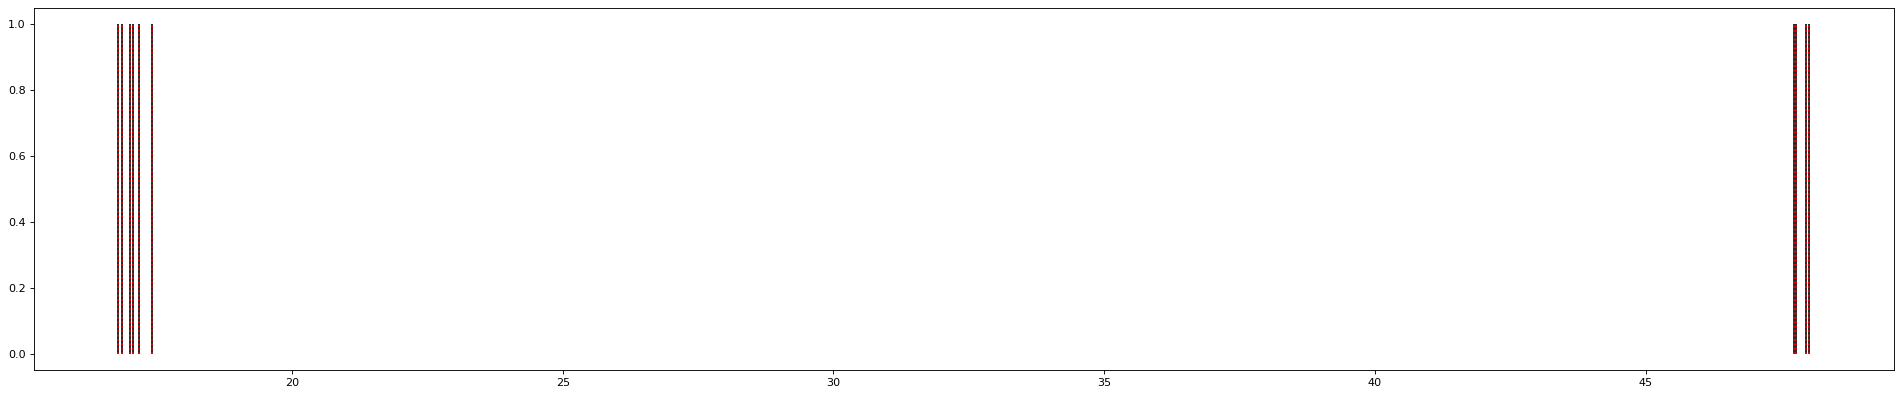

In [43]:
visualize_mapping(sglx_rising_edges, tdt_rising_edges, model)

# Get TDT stimulation times

In [44]:
def get_stim_times(tdt_data):
    '''Extract the time of each stimulation from a loaded TDT block.
    Times are in seconds from the start of the TDT recording.'''
    CntA = tdt_data.epocs.CntA 
    PeA_ = tdt_data.epocs.PeA_
    
    n_strobes = np.size(PeA_.onset) 
    stim_t = np.array([])
    
    for strobe in np.arange(n_strobes):
        strobe_ISI = PeA_.data[strobe] / 1000 # Convert from msec to sec
        n_strobe_stims = CntA.data[strobe] # The number of stimlations in this strobe
        strobe_start = PeA_.onset[strobe] # The time that this strobe started
        strobe_stims = strobe_start + np.arange(n_strobe_stims) * strobe_ISI # The time of each stimulation in this strobe
        stim_t = np.append(stim_t, strobe_stims)
        
    return stim_t  

In [45]:
def get_stim_samples(tdt_data):
    '''Get the sample numbers of each stimulation, based on epoc store estimates.'''
    eS1r = tdt_data.streams.eS1r
    stim_times = get_stim_times(tdt_data)
    return np.rint(stim_times * eS1r.fs).astype('int')

In [46]:
tdt_data = tdt.read_block(tdt_file, evtype=['epocs', 'streams'])
stim_times = get_stim_times(tdt_data)

read from t=0s to t=1015.12s


In [47]:
def visualize_stims(tdt_data, ch, first_stim=0, last_stim=4, before=100, after=100):
    '''Visualize estimated stimulation times (block dotted lines) relative to the stimulator current stream.
    first_stim is the 0-based index of the first stimulation to plot.
    last_stim is the 0-based index of the last stimulation to plot. 
    before/after are the number of samples to plot before the first stim and after the last stim.
    ch is the stimulator current channel to plot.'''
    stim_samples = get_stim_samples(tdt_data)
    samplesToPlot = np.arange(stim_samples[first_stim] - before, stim_samples[last_stim] + after)

    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(samplesToPlot, tdt_data.streams.eS1r.data[ch, samplesToPlot])
    plt.vlines(stim_samples[first_stim : last_stim + 1], 0, 1000, linestyle='dotted', colors='black')

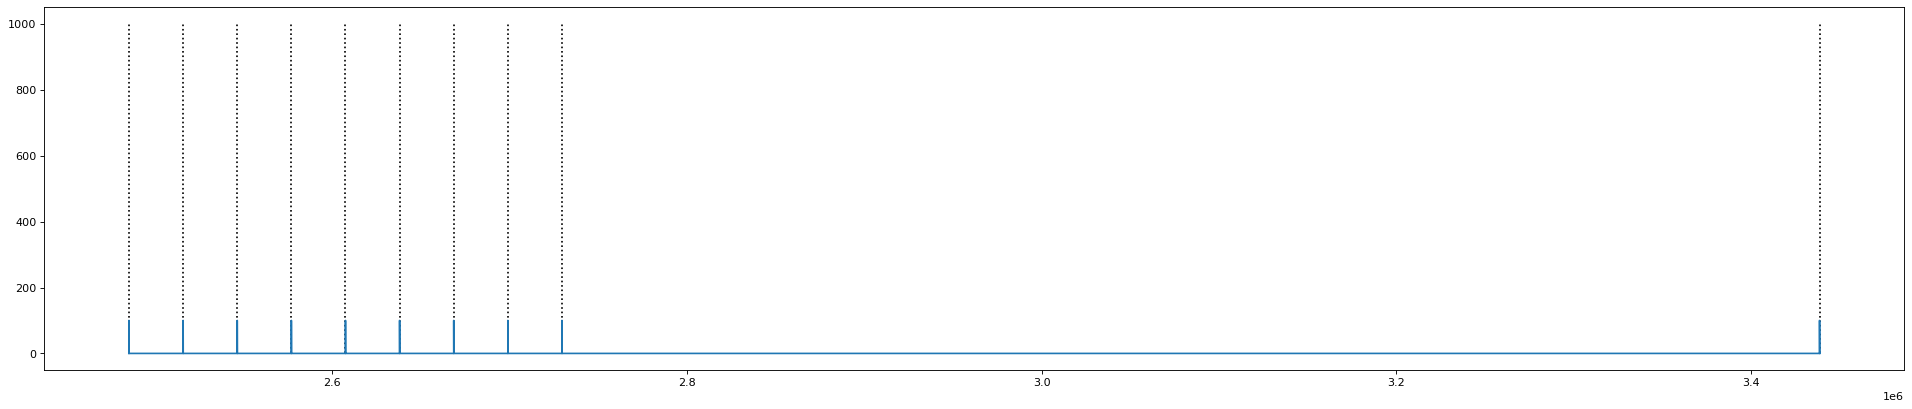

In [49]:
visualize_stims(tdt_data, ch=1, first_stim=1, last_stim=10)

In [50]:
# Remap the stimulation times from TDT time space to SGLX time space, based on sync signal offset and drift between the two systems. 
sglx_stim_times = model.predict(stim_times.reshape((-1, 1)))
sglx_stim_times

array([ 401.13141725,  406.13138315,  411.13134905,  416.13131495,
        421.13128085,  426.13124675,  431.13121265,  436.13117855,
        441.13114445,  446.13111035,  562.31436411,  566.31433688,
        570.31430965,  574.31428242,  578.31425519,  582.31422796,
        586.31420073,  590.31417349,  594.31414626,  598.31411903,
        602.3140918 ,  606.31406457,  610.31403734,  614.31401011,
        618.31398288,  622.31395565,  626.31392842,  630.31390119,
        634.31387396,  638.31384673,  642.3138195 ,  646.31379227,
        650.31376503,  654.3137378 ,  658.31371057,  662.31368334,
        666.31365611,  670.31362888,  674.31360165,  678.31357442,
        682.31354719,  686.31351996,  690.31349273,  694.3134655 ,
        698.31343827,  702.31341104,  706.31338381,  710.31335658,
        714.31332934,  718.31330211,  722.31327488,  726.31324765,
        730.31322042,  734.31319319,  738.31316596,  742.31313873,
        746.3131115 ,  750.31308427,  754.31305704,  758.31302

In [67]:
def matlab_saveas_dialog():
    # Get file from user
    root = Tk()         # create the Tkinter widget
    root.withdraw()     # hide the Tkinter root window

    # Windows specific; forces the window to appear in front
    root.attributes("-topmost", True)

    fullPath = Path(filedialog.asksaveasfilename(title="Save as", defaultextension=".mat", filetypes=(("MATLAB", "*.mat"),)))

    root.destroy()
    
    return fullPath

In [ ]:
# Export the results for use in MATLAB. 
# The names of the SGLX and TDT files used are saved with the data. 
matlab_file = matlab_saveas_dialog()
savemat(matlab_file, {'sglx_stim_times': sglx_stim_times, 'sglx_file': sglx_file.name, 'tdt_file': tdt_file.name})